<a href="https://colab.research.google.com/github/kemaladamr/NLP_Fundamentals/blob/main/Developing_Text_Cassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hierarchical Clustering

In [3]:
from sklearn.datasets import fetch_20newsgroups
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib as mpl
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [6]:
news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True,
                               random_state=42, download_if_missing=True
                               )

In [7]:
news_data['data'][:5]

['From: Steve@Busop.cit.wayne.edu (Steve Teolis)\nSubject: Re: *** TurboGrafx System For SALE ***\nOrganization: Wayne State University\nLines: 38\nDistribution: na\nNNTP-Posting-Host: 141.217.75.24\n\n>TurboGrafx-16 Base Unit (works like new) with:\n>       1 Controller\n>       AC Adapter\n>       Antenna hookup\n>     * Games:\n>         Kieth Courage\n>         Victory Run\n>         Fantasy Zone\n>         Military Madness\n>         Battle Royal\n>         Legendary Axe\n>         Blazing Lasers\n>         Bloody Wolf\n>\n>  --------------------------------------\n>* Will sell games separatley at $25 each\n>  --------------------------------------\n\nYour kidding, $210.00, man o man, you can buy the system new for $49.00 at \nElectronic Boutique and those games are only about $15 - $20.00 brand new.  \nMaybe you should think about that price again if you REALLY need the money.\n\n\n\n\n\n\n                        \n                        \n                        -=-=-=-=-=-=-=-

In [8]:
news_data.target

array([0, 0, 1, ..., 0, 1, 0])

In [9]:
news_data.target_names

['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [11]:
news_data_df = pd.DataFrame({'text': news_data['data'], 'category': news_data.target})
news_data_df.head()

,text,category
0,From: Steve@Busop.cit.wayne.edu (Steve Teolis)...,0
1,From: jks2x@holmes.acc.Virginia.EDU (Jason K. ...,0
2,From: wayne@uva386.schools.virginia.edu (Tony ...,1
3,From: lihan@ccwf.cc.utexas.edu (Bruce G. Bostw...,1
4,From: myoakam@cis.ohio-state.edu (micah r yoak...,0


In [13]:
news_data_df['category'].value_counts()

1    591
0    585
2    377
Name: category, dtype: int64

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))
    if word.lower() not in stop_words])
)

In [18]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,40,50,ac,also,amp,another,anyone,apple,around,article,asking,back,believe,best,better,bible,bit,board,book,box,brian,ca,cable,call,car,card,case,cc,cd,child,...,service,set,shipping,since,software,someone,something,sound,source,state,still,subject,sure,system,take,thanks,thing,think,time,true,two,university,usa,use,used,using,value,version,want,way,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435655,0.0,0.000000,0.0,0.000000,0.127775,0.136811,0.127551,0.133311,0.0,0.0,0.0,0.1496,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125162,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.251172,0.0,0.040491,0.0,0.227027,0.0,0.0,0.0,0.116296,0.0,0.0,0.0,0.154615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.113042,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.376762,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.390137,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.093464,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.178445,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.6485,0.0,0.000000,0.0,0.177319,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.474376,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.128216,0.000000,0.0,0.139195,0.0,0.0,0.099153,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.559678,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1578,0.0000,0.0,0.152058,0.0,0.049026,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.093603,0.130822,0.0,0.000000,0.0,0.0,0.0,0.134289,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.210041,0.0,0.0,0.18822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.537053,0.0,0.057719,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110198,0.154017,0.0,0.154412,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [20]:
dist = 1 - cosine_similarity(tfidf_df)
linkage_matrix = ward(dist)

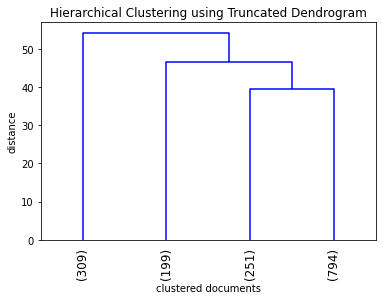

In [23]:
# Truncating the Dendrogram Truncation to show last 4 clusters
plt.title('Hierarchical Clustering using Truncated Dendrogram')
plt.xlabel('clustered documents')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    truncate_mode='lastp', # showing only last p clustering after merging
    p=4, # p is the number of cluster that should remain after merging
    leaf_rotation=90.,
    leaf_font_size=12.
)
plt.show()

In [24]:
k = 4
clusters = fcluster(linkage_matrix, k, criterion='maxclust')
clusters

array([3, 3, 3, ..., 4, 4, 1], dtype=int32)

In [26]:
news_data_df['obtained_clusters'] = clusters
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale',
                                              1:'sci.electronics',
                                              2:'talk.religion.misc'}),
            news_data_df['obtained_clusters'].replace({1:'cluster_1',
                                                       2:'cluster_2',
                                                       3:'cluster_3',
                                                       4:'cluster_4'})
            )

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,155,0,230,200
sci.electronics,110,1,19,461
talk.religion.misc,44,198,2,133


## K-Means Clustering

In [27]:
import seaborn as sns;
sns.set()
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [38]:
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
lemmatizer = WordNetLemmatizer()

In [39]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [40]:
news_data = fetch_20newsgroups(subset='train', categories=categories,
                               shuffle=True, random_state=42, download_if_missing=True)

In [41]:
news_data_df = pd.DataFrame({'text': news_data['data'], 'category': news_data.target})
news_data_df.head()

news_data_df['cleaned_text'] = news_data_df['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))
    if word.lower() not in stop_words])
)

In [42]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,40,50,ac,also,amp,another,anyone,apple,around,article,asking,back,believe,best,better,bible,bit,board,book,box,brian,ca,cable,call,car,card,case,cc,cd,child,...,service,set,shipping,since,software,someone,something,sound,source,state,still,subject,sure,system,take,thanks,thing,think,time,true,two,university,usa,use,used,using,value,version,want,way,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435655,0.0,0.000000,0.0,0.000000,0.127775,0.136811,0.127551,0.133311,0.0,0.0,0.0,0.1496,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125162,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.251172,0.0,0.040491,0.0,0.227027,0.0,0.0,0.0,0.116296,0.0,0.0,0.0,0.154615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.113042,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.376762,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.390137,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.093464,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.178445,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.6485,0.0,0.000000,0.0,0.177319,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.474376,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.128216,0.000000,0.0,0.139195,0.0,0.0,0.099153,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.559678,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1578,0.0000,0.0,0.152058,0.0,0.049026,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.093603,0.130822,0.0,0.000000,0.0,0.0,0.0,0.134289,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.210041,0.0,0.0,0.18822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.537053,0.0,0.057719,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110198,0.154017,0.0,0.154412,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tfidf_df)
y_kmeans = kmeans.predict(tfidf_df)
news_data_df['obtained_clusters'] = y_kmeans

In [44]:
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale',
                                              1:'sci.electronics',
                                              2:'talk.religion.misc'}),
            news_data_df['obtained_clusters'].replace({0:'cluster_1',
                                                       1:'cluster_2',
                                                       2:'cluster_3',
                                                       3:'cluster_4'})
            )

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,369,122,93,1
sci.electronics,9,160,422,0
talk.religion.misc,0,79,68,230


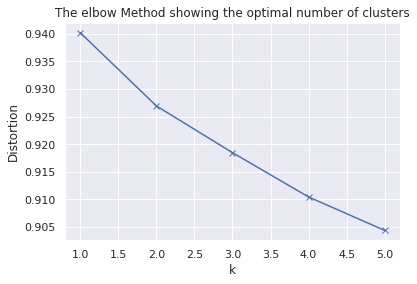

In [45]:
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_df)
    distortions.append(sum(np.min(cdist(tfidf_df, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1))/tfidf_df.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow Method showing the optimal number of clusters')
plt.show()